# MAP 565 : Production Forecasting

## Augustin Boissier & Maxime Pedron

- Le but du mémoire est de faire une analyse statistique d'un ou plusieurs jeux de données au choix. L'objectif est de tirer de l'information pertinente et intéressante à partir de ces données.

- Vous pouvez utiliser un unique jeu de données ou plusieurs jeu de données (n'ayant pas forcément de liens entre eux).
Contrainte: vos données doivent comporter des données de 2021 (année 2021 ou données créés en 2021).

- Sur la première page de votre mémoire: donner le lien pour que je puisse accéder aux données.

-  Si vous avez vraiment des difficultés à trouver un jeu de données intéressant tenez-moi au courant.

- Langage python, inutile de me mettre les codes. Bien sûr vous pouvez vous servir de packages existants.

- 15 pages maximum.

- Pour votre analyse, vous devrez utiliser nécessairement :

---- Les séries temporelles linéaires (cours de M. Violante).

Et au moins trois des quatre outils suivants

---- Les processus de Hawkes

---- Le théorie des extrêmes

---- Les copules

---- Les processus GARCH

- Bonus pour l'utilisation des éléments vus dans les cours les matrices aléatoires et lors de la dernière séance (qui portera sur du machine learning).

- Mémoire à faire à 2 (obligatoirement).

- A me rendre sous format pdf obligatoire (pas notebook Python) pour le 10 avril 2022, dans un mail dont le titre sera "Mémoire statistique" à

https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [98]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import pandas as pd

# df = df.drop(['date','time'], axis=1)

In [99]:
df_train = pd.read_csv("data/train.csv").drop(columns=['Unnamed: 0'])
df_test = pd.read_csv("data/test.csv").drop(columns=['Unnamed: 0'])
y_test = df_test['Weighted_Price']
df_test = df_test.drop('Weighted_Price',axis=1)
print("Importation terminée")

Importation terminée


Text(0, 0.5, 'USD')

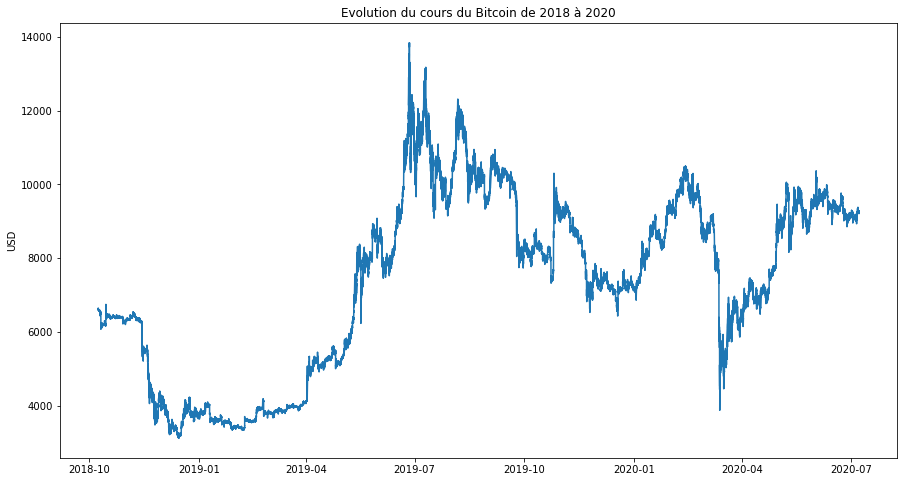

In [101]:
#dt = datetime.fromtimestamp(df_train['Timestamp'])
dt = df_train['Timestamp'].apply(lambda d: datetime.fromtimestamp(d))
plt.figure(figsize=(15, 8))
plt.plot(dt,df_train['Weighted_Price'])
plt.title("Evolution du cours du Bitcoin de 2018 à 2020")
plt.ylabel("USD")

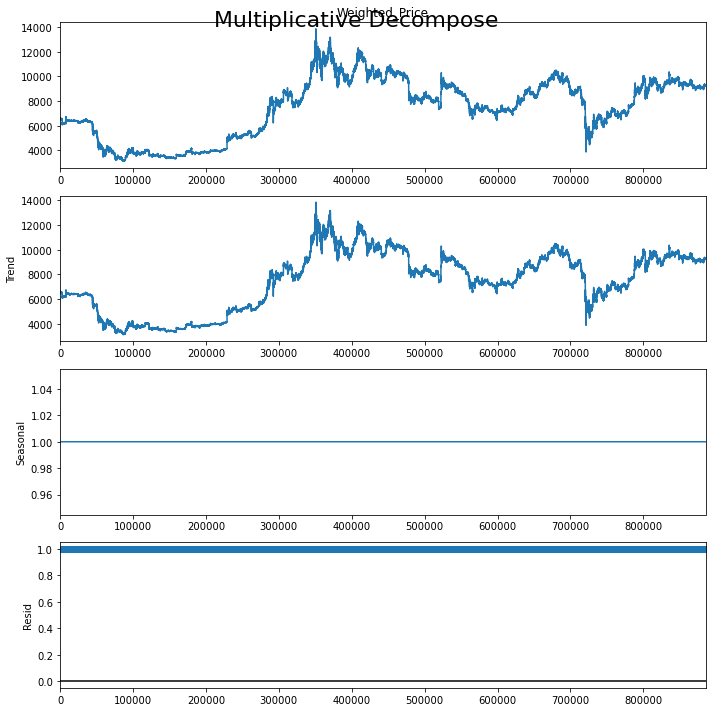

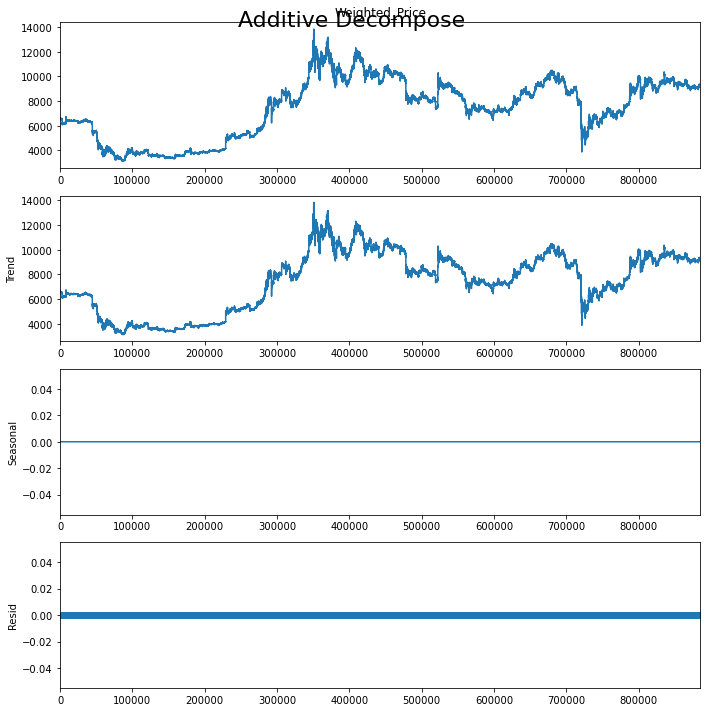

In [102]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

#format = '%Y-%m-%d %H:%M:%S'
#df_train['Datetime'] = pd.to_datetime(df_train['Time'], format=format)
#df_train = df_train.set_index(pd.DatetimeIndex(df_train['Datetime']))

# Multiplicative Decomposition 
result_mul = seasonal_decompose(df_train['Weighted_Price'], model='multiplicative',period =1,extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df_train['Weighted_Price'], model='additive', period=1,extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)

result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [ ]:
# Augmented Dickey Fuller test
#the null hypothesis is the time series possesses a unit root and is non-stationary
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df_train['Weighted_Price'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(df_train['Weighted_Price'], regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

So, if the P-Value in ADH test is less than the significance level (0.05), you reject the null hypothesis. The KPSS test, on the other hand, is used to test for trend stationarity. The null hypothesis and the P-Value interpretation is just the opposite of ADH test. The below code implements these two tests using statsmodels package in python.

In [50]:
#Combining ARIMA and GARCH
N = 100
M = 30
import arch
import pmdarima 
import statsmodels.tsa.arima_model as stm
from arch import *
from pmdarima import *

df = df_train[len(df_train)-N:]['Weighted_Price']
df
for i in range(M):
    # fit ARIMA on returns 
    arima_model = pmdarima.auto_arima(df)
    p, d, q = arima_model.order
    arima_residuals = arima_model.arima_res_.resid

    # fit a GARCH(1,1) model on the residuals of the ARIMA model
    garch = arch_model(arima_residuals, p=1, q=1)
    garch_fitted = garch.fit()

    # Use ARIMA to predict mu
    predicted_mu = arima_model.predict(n_periods=1)[0]
    # Use GARCH to predict the residual
    garch_forecast = garch_fitted.forecast(horizon=1)
    predicted_et = garch_forecast.mean['h.1'].iloc[-1]
    # Combine both models' output: yt = mu + et
    prediction = predicted_mu + predicted_et
    df.loc[len(df.index)] = prediction
#https://medium.com/analytics-vidhya/arima-garch-forecasting-with-python-7a3f797de3ff

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.419e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3078.464608196352
Iteration:      2,   Func. Count:     12,   Neg. LLF: 655.4477344524298
Iteration:      3,   Func. Count:     17,   Neg. LLF: 653.1463986472831
Iteration:      4,   Func. Count:     22,   Neg. LLF: 646.0827082110803
Iteration:      5,   Func. Count:     27,   Neg. LLF: 644.1749350401478
Iteration:      6,   Func. Count:     32,   Neg. LLF: 644.0070910166942
Iteration:      7,   Func. Count:     37,   Neg. LLF: 643.759117685346
Iteration:      8,   Func. Count:     42,   Neg. LLF: 642.2758115323011
Iteration:      9,   Func. Count:     47,   Neg. LLF: 638.7921175787867
Iteration:     10,   Func. Count:     52,   Neg. LLF: 634.5384548299324
Iteration:     11,   Func. Count:     57,   Neg. LLF: 630.6776234341601
Iteration:     12,   Func. Count:     62,   Neg. LLF: 629.6187607881185
Iteration:     13,   Func. Count:     67,   Neg. LLF: 629.3626826194164
Iteration:     14,   Func. Count:     72,   Neg. LLF: 629.3524641

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.337e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3108.753634751332
Iteration:      2,   Func. Count:     12,   Neg. LLF: 661.1668770931457
Iteration:      3,   Func. Count:     17,   Neg. LLF: 658.814315980412
Iteration:      4,   Func. Count:     22,   Neg. LLF: 651.6043825445706
Iteration:      5,   Func. Count:     27,   Neg. LLF: 649.6831961381182
Iteration:      6,   Func. Count:     32,   Neg. LLF: 649.5084163378906
Iteration:      7,   Func. Count:     37,   Neg. LLF: 649.2619855717277
Iteration:      8,   Func. Count:     42,   Neg. LLF: 647.7748189987865
Iteration:      9,   Func. Count:     47,   Neg. LLF: 643.7068943997983
Iteration:     10,   Func. Count:     52,   Neg. LLF: 639.4365115959425
Iteration:     11,   Func. Count:     57,   Neg. LLF: 635.9039006919197
Iteration:     12,   Func. Count:     62,   Neg. LLF: 635.0420176804233
Iteration:     13,   Func. Count:     67,   Neg. LLF: 634.8447885252762
Iteration:     14,   Func. Count:     72,   Neg. LLF: 634.8395744

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.256e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3139.0357871344827
Iteration:      2,   Func. Count:     12,   Neg. LLF: 666.8800386594472
Iteration:      3,   Func. Count:     17,   Neg. LLF: 664.4758387172462
Iteration:      4,   Func. Count:     22,   Neg. LLF: 657.1203610388035
Iteration:      5,   Func. Count:     27,   Neg. LLF: 655.1887795904378
Iteration:      6,   Func. Count:     32,   Neg. LLF: 655.0073569738856
Iteration:      7,   Func. Count:     37,   Neg. LLF: 654.7609589045604
Iteration:      8,   Func. Count:     42,   Neg. LLF: 653.2680065664116
Iteration:      9,   Func. Count:     47,   Neg. LLF: 648.6456539999012
Iteration:     10,   Func. Count:     52,   Neg. LLF: 644.3691695377834
Iteration:     11,   Func. Count:     57,   Neg. LLF: 641.180841603332
Iteration:     12,   Func. Count:     62,   Neg. LLF: 640.4768016886732
Iteration:     13,   Func. Count:     67,   Neg. LLF: 640.3267602597346
Iteration:     14,   Func. Count:     72,   Neg. LLF: 640.324060

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.177e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3169.306940445998
Iteration:      2,   Func. Count:     12,   Neg. LLF: 672.5870382362775
Iteration:      3,   Func. Count:     17,   Neg. LLF: 670.1306285490115
Iteration:      4,   Func. Count:     22,   Neg. LLF: 662.6279890998397
Iteration:      5,   Func. Count:     27,   Neg. LLF: 660.6855966288715
Iteration:      6,   Func. Count:     32,   Neg. LLF: 660.4970778410424
Iteration:      7,   Func. Count:     37,   Neg. LLF: 660.2510908188734
Iteration:      8,   Func. Count:     42,   Neg. LLF: 658.7571783734305
Iteration:      9,   Func. Count:     47,   Neg. LLF: 653.4767358176973
Iteration:     10,   Func. Count:     52,   Neg. LLF: 649.2273662176586
Iteration:     11,   Func. Count:     57,   Neg. LLF: 646.4606271189042
Iteration:     12,   Func. Count:     62,   Neg. LLF: 645.908217978611
Iteration:     13,   Func. Count:     67,   Neg. LLF: 645.8021791121317
Iteration:     14,   Func. Count:     72,   Neg. LLF: 645.8009141

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.099e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3199.5824461725797
Iteration:      2,   Func. Count:     12,   Neg. LLF: 678.2883301818288
Iteration:      3,   Func. Count:     17,   Neg. LLF: 675.7792702973366
Iteration:      4,   Func. Count:     22,   Neg. LLF: 668.1283754737403
Iteration:      5,   Func. Count:     27,   Neg. LLF: 666.1759583839203
Iteration:      6,   Func. Count:     32,   Neg. LLF: 665.9801527160638
Iteration:      7,   Func. Count:     37,   Neg. LLF: 665.7342425490627
Iteration:      8,   Func. Count:     42,   Neg. LLF: 664.2416102792395
Iteration:      9,   Func. Count:     47,   Neg. LLF: 658.2502072226275
Iteration:     10,   Func. Count:     52,   Neg. LLF: 654.0822107809807
Iteration:     11,   Func. Count:     57,   Neg. LLF: 651.764816042856
Iteration:     12,   Func. Count:     62,   Neg. LLF: 651.3433904652825
Iteration:     13,   Func. Count:     67,   Neg. LLF: 651.2725118684621
Iteration:     14,   Func. Count:     72,   Neg. LLF: 651.272005

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.022e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3229.852414754736
Iteration:      2,   Func. Count:     12,   Neg. LLF: 683.983961743373
Iteration:      3,   Func. Count:     17,   Neg. LLF: 681.4217313736165
Iteration:      4,   Func. Count:     22,   Neg. LLF: 673.6217572198912
Iteration:      5,   Func. Count:     27,   Neg. LLF: 671.6600399855978
Iteration:      6,   Func. Count:     32,   Neg. LLF: 671.4567444307208
Iteration:      7,   Func. Count:     37,   Neg. LLF: 671.2106282826516
Iteration:      8,   Func. Count:     42,   Neg. LLF: 669.7207125790889
Iteration:      9,   Func. Count:     47,   Neg. LLF: 663.3540913067088
Iteration:     10,   Func. Count:     52,   Neg. LLF: 658.6839981745482
Iteration:     11,   Func. Count:     57,   Neg. LLF: 657.0900239589083
Iteration:     12,   Func. Count:     62,   Neg. LLF: 656.7791980147526
Iteration:     13,   Func. Count:     67,   Neg. LLF: 656.7374525901632
Iteration:     14,   Func. Count:     72,   Neg. LLF: 656.7372151

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.947e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3260.1157120695484
Iteration:      2,   Func. Count:     12,   Neg. LLF: 689.6739712144162
Iteration:      3,   Func. Count:     17,   Neg. LLF: 687.0581279467768
Iteration:      4,   Func. Count:     22,   Neg. LLF: 679.1080324063067
Iteration:      5,   Func. Count:     27,   Neg. LLF: 677.137786522119
Iteration:      6,   Func. Count:     32,   Neg. LLF: 676.9267956445211
Iteration:      7,   Func. Count:     37,   Neg. LLF: 676.6801922452789
Iteration:      8,   Func. Count:     42,   Neg. LLF: 675.1941216457182
Iteration:      9,   Func. Count:     47,   Neg. LLF: 668.7074807432253
Iteration:     10,   Func. Count:     52,   Neg. LLF: 663.355363551179
Iteration:     11,   Func. Count:     57,   Neg. LLF: 662.4044751522852
Iteration:     12,   Func. Count:     62,   Neg. LLF: 662.2140835917703
Iteration:     13,   Func. Count:     67,   Neg. LLF: 662.1968799147537
Iteration:     14,   Func. Count:     72,   Neg. LLF: 662.1968001

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.874e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3290.3689909641475
Iteration:      2,   Func. Count:     12,   Neg. LLF: 695.3588009286962
Iteration:      3,   Func. Count:     17,   Neg. LLF: 692.6888896604396
Iteration:      4,   Func. Count:     22,   Neg. LLF: 684.587619456423
Iteration:      5,   Func. Count:     27,   Neg. LLF: 682.6093740567821
Iteration:      6,   Func. Count:     32,   Neg. LLF: 682.3904759941354
Iteration:      7,   Func. Count:     37,   Neg. LLF: 682.1433292364427
Iteration:      8,   Func. Count:     42,   Neg. LLF: 680.6620051115787
Iteration:      9,   Func. Count:     47,   Neg. LLF: 674.1295222375005
Iteration:     10,   Func. Count:     52,   Neg. LLF: 668.2554030461465
Iteration:     11,   Func. Count:     57,   Neg. LLF: 667.7539925263395
Iteration:     12,   Func. Count:     62,   Neg. LLF: 667.6554798913287
Iteration:     13,   Func. Count:     67,   Neg. LLF: 667.6508878588821
Iteration:     14,   Func. Count:     72,   Neg. LLF: 667.650862

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.802e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3320.6175008619525
Iteration:      2,   Func. Count:     12,   Neg. LLF: 701.0380372878134
Iteration:      3,   Func. Count:     17,   Neg. LLF: 698.3134681736908
Iteration:      4,   Func. Count:     22,   Neg. LLF: 690.059454872104
Iteration:      5,   Func. Count:     27,   Neg. LLF: 688.0732739315291
Iteration:      6,   Func. Count:     32,   Neg. LLF: 687.8459637666168
Iteration:      7,   Func. Count:     37,   Neg. LLF: 687.5983490491747
Iteration:      8,   Func. Count:     42,   Neg. LLF: 686.1259075700942
Iteration:      9,   Func. Count:     47,   Neg. LLF: 679.6069995307506
Iteration:     10,   Func. Count:     52,   Neg. LLF: 673.340638198704
Iteration:     11,   Func. Count:     57,   Neg. LLF: 673.1374380612255
Iteration:     12,   Func. Count:     62,   Neg. LLF: 673.0983871936132
Iteration:     13,   Func. Count:     67,   Neg. LLF: 673.0980350274544
Iteration:     14,   Func. Count:     72,   Neg. LLF: 673.0980249

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.731e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3350.877606032663
Iteration:      2,   Func. Count:     12,   Neg. LLF: 706.7173183935469
Iteration:      3,   Func. Count:     17,   Neg. LLF: 703.9378720944185
Iteration:      4,   Func. Count:     22,   Neg. LLF: 695.5317701726447
Iteration:      5,   Func. Count:     27,   Neg. LLF: 693.5392757667015
Iteration:      6,   Func. Count:     32,   Neg. LLF: 693.3039525036802
Iteration:      7,   Func. Count:     37,   Neg. LLF: 693.0547947613671
Iteration:      8,   Func. Count:     42,   Neg. LLF: 691.5846917090344
Iteration:      9,   Func. Count:     47,   Neg. LLF: 685.086466770821
Iteration:     10,   Func. Count:     52,   Neg. LLF: 678.6379760559732
Iteration:     11,   Func. Count:     57,   Neg. LLF: 678.560667010403
Iteration:     12,   Func. Count:     62,   Neg. LLF: 678.5465499208381
Iteration:     13,   Func. Count:     67,   Neg. LLF: 678.5465010186354
Iteration:     14,   Func. Count:     72,   Neg. LLF: 678.54648220

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.661e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3381.1219566203254
Iteration:      2,   Func. Count:     12,   Neg. LLF: 712.3856627910477
Iteration:      3,   Func. Count:     17,   Neg. LLF: 709.5507613312727
Iteration:      4,   Func. Count:     22,   Neg. LLF: 700.990966944564
Iteration:      5,   Func. Count:     27,   Neg. LLF: 698.9926669604669
Iteration:      6,   Func. Count:     32,   Neg. LLF: 698.7487999462393
Iteration:      7,   Func. Count:     37,   Neg. LLF: 698.4983859704437
Iteration:      8,   Func. Count:     42,   Neg. LLF: 697.033974732859
Iteration:      9,   Func. Count:     47,   Neg. LLF: 690.5855750922104
Iteration:     10,   Func. Count:     52,   Neg. LLF: 684.0215545334993
Iteration:     11,   Func. Count:     57,   Neg. LLF: 683.9874659598231
Iteration:     12,   Func. Count:     62,   Neg. LLF: 683.9840397325223
Iteration:     13,   Func. Count:     67,   Neg. LLF: 683.9839763145759
Iteration:     14,   Func. Count:     72,   Neg. LLF: 683.9953834

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.593e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3411.359768421044
Iteration:      2,   Func. Count:     12,   Neg. LLF: 718.0479979601304
Iteration:      3,   Func. Count:     17,   Neg. LLF: 715.1571572480563
Iteration:      4,   Func. Count:     22,   Neg. LLF: 706.4429376079702
Iteration:      5,   Func. Count:     27,   Neg. LLF: 704.4398743764183
Iteration:      6,   Func. Count:     32,   Neg. LLF: 704.187241359492
Iteration:      7,   Func. Count:     37,   Neg. LLF: 703.9354482346434
Iteration:      8,   Func. Count:     42,   Neg. LLF: 702.4765273075601
Iteration:      9,   Func. Count:     47,   Neg. LLF: 696.0865043890303
Iteration:     10,   Func. Count:     52,   Neg. LLF: 689.4692480761418
Iteration:     11,   Func. Count:     57,   Neg. LLF: 689.4171128980789
Iteration:     12,   Func. Count:     62,   Neg. LLF: 689.4160685737421
Iteration:     13,   Func. Count:     67,   Neg. LLF: 689.4159863327031
Iteration:     14,   Func. Count:     72,   Neg. LLF: 689.7038972

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.525e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3441.573566793866
Iteration:      2,   Func. Count:     12,   Neg. LLF: 723.7050260571293
Iteration:      3,   Func. Count:     17,   Neg. LLF: 720.7577345787017
Iteration:      4,   Func. Count:     22,   Neg. LLF: 711.888150492123
Iteration:      5,   Func. Count:     27,   Neg. LLF: 709.8810632391833
Iteration:      6,   Func. Count:     32,   Neg. LLF: 709.6196115964759
Iteration:      7,   Func. Count:     37,   Neg. LLF: 709.3661406635223
Iteration:      8,   Func. Count:     42,   Neg. LLF: 707.9119921333711
Iteration:      9,   Func. Count:     47,   Neg. LLF: 701.5820413033373
Iteration:     10,   Func. Count:     52,   Neg. LLF: 694.9443527024882
Iteration:     11,   Func. Count:     57,   Neg. LLF: 694.8444317205235
Iteration:     12,   Func. Count:     62,   Neg. LLF: 694.8426489344661
Iteration:     13,   Func. Count:     67,   Neg. LLF: 694.8426514455373
Optimization terminated successfully    (Exit mode 0)
           

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.459e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3471.821985857702
Iteration:      2,   Func. Count:     12,   Neg. LLF: 729.3568362203704
Iteration:      3,   Func. Count:     17,   Neg. LLF: 726.3526526812522
Iteration:      4,   Func. Count:     22,   Neg. LLF: 717.3266649191348
Iteration:      5,   Func. Count:     27,   Neg. LLF: 715.3164695260873
Iteration:      6,   Func. Count:     32,   Neg. LLF: 715.0458285038331
Iteration:      7,   Func. Count:     37,   Neg. LLF: 714.7905829690504
Iteration:      8,   Func. Count:     42,   Neg. LLF: 713.3410036397902
Iteration:      9,   Func. Count:     47,   Neg. LLF: 707.0711229196461
Iteration:     10,   Func. Count:     52,   Neg. LLF: 700.4236990735064
Iteration:     11,   Func. Count:     57,   Neg. LLF: 700.2670811008894
Iteration:     12,   Func. Count:     62,   Neg. LLF: 700.2640513710722
Iteration:     13,   Func. Count:     67,   Neg. LLF: 700.2639561175647
Iteration:     14,   Func. Count:     72,   Neg. LLF: 700.263919

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.395e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3502.036816478693
Iteration:      2,   Func. Count:     12,   Neg. LLF: 735.0039131152747
Iteration:      3,   Func. Count:     17,   Neg. LLF: 731.9424032154266
Iteration:      4,   Func. Count:     22,   Neg. LLF: 722.7590323842265
Iteration:      5,   Func. Count:     27,   Neg. LLF: 720.7462343176545
Iteration:      6,   Func. Count:     32,   Neg. LLF: 720.4662518889837
Iteration:      7,   Func. Count:     37,   Neg. LLF: 720.2090869418842
Iteration:      8,   Func. Count:     42,   Neg. LLF: 718.7634420036475
Iteration:      9,   Func. Count:     47,   Neg. LLF: 712.5506673921255
Iteration:     10,   Func. Count:     52,   Neg. LLF: 705.8940773733548
Iteration:     11,   Func. Count:     57,   Neg. LLF: 705.6844203460922
Iteration:     12,   Func. Count:     62,   Neg. LLF: 705.6802989082305
Iteration:     13,   Func. Count:     67,   Neg. LLF: 705.6801152961702
Iteration:     14,   Func. Count:     72,   Neg. LLF: 705.680115

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.331e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3532.2688960354835
Iteration:      2,   Func. Count:     12,   Neg. LLF: 740.645599919844
Iteration:      3,   Func. Count:     17,   Neg. LLF: 737.52597351766
Iteration:      4,   Func. Count:     22,   Neg. LLF: 728.1846108906891
Iteration:      5,   Func. Count:     27,   Neg. LLF: 726.1701544738337
Iteration:      6,   Func. Count:     32,   Neg. LLF: 725.880631006268
Iteration:      7,   Func. Count:     37,   Neg. LLF: 725.6213233861315
Iteration:      8,   Func. Count:     42,   Neg. LLF: 724.178540909173
Iteration:      9,   Func. Count:     47,   Neg. LLF: 718.0164247162525
Iteration:     10,   Func. Count:     52,   Neg. LLF: 711.3493009734156
Iteration:     11,   Func. Count:     57,   Neg. LLF: 711.0960047814674
Iteration:     12,   Func. Count:     62,   Neg. LLF: 711.0910656851286
Iteration:     13,   Func. Count:     67,   Neg. LLF: 711.0909751741189
Iteration:     14,   Func. Count:     72,   Neg. LLF: 711.0909459208

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.268e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3562.474148354022
Iteration:      2,   Func. Count:     12,   Neg. LLF: 746.2826006125517
Iteration:      3,   Func. Count:     17,   Neg. LLF: 743.1047155247791
Iteration:      4,   Func. Count:     22,   Neg. LLF: 733.6041453469558
Iteration:      5,   Func. Count:     27,   Neg. LLF: 731.5885381595605
Iteration:      6,   Func. Count:     32,   Neg. LLF: 731.2892093085381
Iteration:      7,   Func. Count:     37,   Neg. LLF: 731.0276825606092
Iteration:      8,   Func. Count:     42,   Neg. LLF: 729.5871809305436
Iteration:      9,   Func. Count:     47,   Neg. LLF: 723.4704747371736
Iteration:     10,   Func. Count:     52,   Neg. LLF: 716.7884943217733
Iteration:     11,   Func. Count:     57,   Neg. LLF: 716.5021234697601
Iteration:     12,   Func. Count:     62,   Neg. LLF: 716.4968157606696
Iteration:     13,   Func. Count:     67,   Neg. LLF: 716.4967613355743
Iteration:     14,   Func. Count:     72,   Neg. LLF: 716.636386

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.207e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3592.7067534632947
Iteration:      2,   Func. Count:     12,   Neg. LLF: 751.9142916377596
Iteration:      3,   Func. Count:     17,   Neg. LLF: 748.6773447401183
Iteration:      4,   Func. Count:     22,   Neg. LLF: 739.0169670790834
Iteration:      5,   Func. Count:     27,   Neg. LLF: 737.0010147171032
Iteration:      6,   Func. Count:     32,   Neg. LLF: 736.6917886754344
Iteration:      7,   Func. Count:     37,   Neg. LLF: 736.4277854337486
Iteration:      8,   Func. Count:     42,   Neg. LLF: 734.9888266732144
Iteration:      9,   Func. Count:     47,   Neg. LLF: 728.9112112524359
Iteration:     10,   Func. Count:     52,   Neg. LLF: 722.2122530583729
Iteration:     11,   Func. Count:     57,   Neg. LLF: 721.9029378653596
Iteration:     12,   Func. Count:     62,   Neg. LLF: 721.8974663618807
Iteration:     13,   Func. Count:     67,   Neg. LLF: 721.8973318603763
Iteration:     14,   Func. Count:     72,   Neg. LLF: 721.89732

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.146e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3622.9107150281475
Iteration:      2,   Func. Count:     12,   Neg. LLF: 757.5413688935587
Iteration:      3,   Func. Count:     17,   Neg. LLF: 754.2450199463814
Iteration:      4,   Func. Count:     22,   Neg. LLF: 744.4238907248813
Iteration:      5,   Func. Count:     27,   Neg. LLF: 742.4082091644508
Iteration:      6,   Func. Count:     32,   Neg. LLF: 742.0888891439747
Iteration:      7,   Func. Count:     37,   Neg. LLF: 741.8222635450276
Iteration:      8,   Func. Count:     42,   Neg. LLF: 740.3833715289253
Iteration:      9,   Func. Count:     47,   Neg. LLF: 734.3364619797248
Iteration:     10,   Func. Count:     52,   Neg. LLF: 727.6217697720498
Iteration:     11,   Func. Count:     57,   Neg. LLF: 727.2986616501811
Iteration:     12,   Func. Count:     62,   Neg. LLF: 727.2930101033037
Iteration:     13,   Func. Count:     67,   Neg. LLF: 727.2929452787349
Iteration:     14,   Func. Count:     72,   Neg. LLF: 727.30703

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.087e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3653.113986727458
Iteration:      2,   Func. Count:     12,   Neg. LLF: 763.1631796003426
Iteration:      3,   Func. Count:     17,   Neg. LLF: 759.8070129575702
Iteration:      4,   Func. Count:     22,   Neg. LLF: 749.8242303747226
Iteration:      5,   Func. Count:     27,   Neg. LLF: 747.8095753651685
Iteration:      6,   Func. Count:     32,   Neg. LLF: 747.4798591654197
Iteration:      7,   Func. Count:     37,   Neg. LLF: 747.2106218169971
Iteration:      8,   Func. Count:     42,   Neg. LLF: 745.7710925292915
Iteration:      9,   Func. Count:     47,   Neg. LLF: 739.7497643612389
Iteration:     10,   Func. Count:     52,   Neg. LLF: 733.0199691030899
Iteration:     11,   Func. Count:     57,   Neg. LLF: 732.6892874128806
Iteration:     12,   Func. Count:     62,   Neg. LLF: 732.6835204832653
Iteration:     13,   Func. Count:     67,   Neg. LLF: 732.683444854469
Iteration:     14,   Func. Count:     72,   Neg. LLF: 732.6834238

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.028e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3683.3214293439523
Iteration:      2,   Func. Count:     12,   Neg. LLF: 768.7810421869918
Iteration:      3,   Func. Count:     17,   Neg. LLF: 765.3645492617994
Iteration:      4,   Func. Count:     22,   Neg. LLF: 755.2191662677204
Iteration:      5,   Func. Count:     27,   Neg. LLF: 753.2061712996352
Iteration:      6,   Func. Count:     32,   Neg. LLF: 752.8659652900026
Iteration:      7,   Func. Count:     37,   Neg. LLF: 752.5937761910263
Iteration:      8,   Func. Count:     42,   Neg. LLF: 751.1523944613643
Iteration:      9,   Func. Count:     47,   Neg. LLF: 745.148619587592
Iteration:     10,   Func. Count:     52,   Neg. LLF: 738.4070488662112
Iteration:     11,   Func. Count:     57,   Neg. LLF: 738.0752551651165
Iteration:     12,   Func. Count:     62,   Neg. LLF: 738.0693765036676
Iteration:     13,   Func. Count:     67,   Neg. LLF: 755.9756558428901
Iteration:     14,   Func. Count:     75,   Neg. LLF: 738.069345

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.97e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3713.502691438623
Iteration:      2,   Func. Count:     12,   Neg. LLF: 774.3934609219373
Iteration:      3,   Func. Count:     17,   Neg. LLF: 770.9162689608221
Iteration:      4,   Func. Count:     22,   Neg. LLF: 760.6075097240615
Iteration:      5,   Func. Count:     27,   Neg. LLF: 758.5968793066592
Iteration:      6,   Func. Count:     32,   Neg. LLF: 758.2458503601124
Iteration:      7,   Func. Count:     37,   Neg. LLF: 757.9708548994261
Iteration:      8,   Func. Count:     42,   Neg. LLF: 756.5266315213173
Iteration:      9,   Func. Count:     47,   Neg. LLF: 750.5345750298314
Iteration:     10,   Func. Count:     52,   Neg. LLF: 743.7854838328718
Iteration:     11,   Func. Count:     57,   Neg. LLF: 743.4560181424531
Iteration:     12,   Func. Count:     62,   Neg. LLF: 743.4500622741622
Iteration:     13,   Func. Count:     67,   Neg. LLF: 743.4500726600465
Iteration:     14,   Func. Count:     73,   Neg. LLF: 743.450011

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.914e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3743.7025130838174
Iteration:      2,   Func. Count:     12,   Neg. LLF: 780.002177468941
Iteration:      3,   Func. Count:     17,   Neg. LLF: 776.4636691600973
Iteration:      4,   Func. Count:     22,   Neg. LLF: 765.9907502010988
Iteration:      5,   Func. Count:     27,   Neg. LLF: 763.9831079838877
Iteration:      6,   Func. Count:     32,   Neg. LLF: 763.6211528232892
Iteration:      7,   Func. Count:     37,   Neg. LLF: 763.3429908866877
Iteration:      8,   Func. Count:     42,   Neg. LLF: 761.8948665578027
Iteration:      9,   Func. Count:     47,   Neg. LLF: 755.9081065726929
Iteration:     10,   Func. Count:     52,   Neg. LLF: 749.1569612091249
Iteration:     11,   Func. Count:     57,   Neg. LLF: 748.832489918549
Iteration:     12,   Func. Count:     62,   Neg. LLF: 748.8265348014972
Iteration:     13,   Func. Count:     67,   Neg. LLF: 748.8264370432407
Iteration:     14,   Func. Count:     72,   Neg. LLF: 748.8264293

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.858e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3773.8780581278475
Iteration:      2,   Func. Count:     12,   Neg. LLF: 785.6049174608831
Iteration:      3,   Func. Count:     17,   Neg. LLF: 782.0048064814038
Iteration:      4,   Func. Count:     22,   Neg. LLF: 771.3669561651609
Iteration:      5,   Func. Count:     27,   Neg. LLF: 769.3631298598208
Iteration:      6,   Func. Count:     32,   Neg. LLF: 768.9900358901765
Iteration:      7,   Func. Count:     37,   Neg. LLF: 768.7087217205349
Iteration:      8,   Func. Count:     42,   Neg. LLF: 767.2552542226729
Iteration:      9,   Func. Count:     47,   Neg. LLF: 761.2676109267073
Iteration:     10,   Func. Count:     52,   Neg. LLF: 754.5204846685448
Iteration:     11,   Func. Count:     57,   Neg. LLF: 754.2035272374537
Iteration:     12,   Func. Count:     62,   Neg. LLF: 754.1975084592881
Iteration:     13,   Func. Count:     67,   Neg. LLF: 754.197397452365
Iteration:     14,   Func. Count:     72,   Neg. LLF: 754.197371

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.803e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3804.067435271493
Iteration:      2,   Func. Count:     12,   Neg. LLF: 791.2028362339553
Iteration:      3,   Func. Count:     17,   Neg. LLF: 787.5404774702969
Iteration:      4,   Func. Count:     22,   Neg. LLF: 776.7370267081618
Iteration:      5,   Func. Count:     27,   Neg. LLF: 774.7378230900415
Iteration:      6,   Func. Count:     32,   Neg. LLF: 774.3534190470374
Iteration:      7,   Func. Count:     37,   Neg. LLF: 774.0687304899494
Iteration:      8,   Func. Count:     42,   Neg. LLF: 772.6089874101663
Iteration:      9,   Func. Count:     47,   Neg. LLF: 766.6147678480045
Iteration:     10,   Func. Count:     52,   Neg. LLF: 759.8776267309953
Iteration:     11,   Func. Count:     57,   Neg. LLF: 759.5696332735902
Iteration:     12,   Func. Count:     62,   Neg. LLF: 759.5636075285944
Iteration:     13,   Func. Count:     67,   Neg. LLF: 759.5636213674796
Iteration:     14,   Func. Count:     73,   Neg. LLF: 759.563522

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.749e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexi

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3834.246842201175
Iteration:      2,   Func. Count:     12,   Neg. LLF: 796.7960966037261
Iteration:      3,   Func. Count:     17,   Neg. LLF: 793.0712531979628
Iteration:      4,   Func. Count:     22,   Neg. LLF: 782.1012460732568
Iteration:      5,   Func. Count:     27,   Neg. LLF: 780.1073010611998
Iteration:      6,   Func. Count:     32,   Neg. LLF: 779.7113840881805
Iteration:      7,   Func. Count:     37,   Neg. LLF: 779.4232875607114
Iteration:      8,   Func. Count:     42,   Neg. LLF: 777.9560170912735
Iteration:      9,   Func. Count:     47,   Neg. LLF: 771.9503286902907
Iteration:     10,   Func. Count:     52,   Neg. LLF: 765.2288680988739
Iteration:     11,   Func. Count:     57,   Neg. LLF: 764.9309936469009
Iteration:     12,   Func. Count:     62,   Neg. LLF: 764.9250020078424
Iteration:     13,   Func. Count:     67,   Neg. LLF: 764.9249416012912
Iteration:     14,   Func. Count:     72,   Neg. LLF: 764.924914

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.696e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3864.438224013712
Iteration:      2,   Func. Count:     12,   Neg. LLF: 802.3845555237848
Iteration:      3,   Func. Count:     17,   Neg. LLF: 798.5965291845347
Iteration:      4,   Func. Count:     22,   Neg. LLF: 787.459273842719
Iteration:      5,   Func. Count:     27,   Neg. LLF: 785.4713764917417
Iteration:      6,   Func. Count:     32,   Neg. LLF: 785.0638019386776
Iteration:      7,   Func. Count:     37,   Neg. LLF: 784.7720634138179
Iteration:      8,   Func. Count:     42,   Neg. LLF: 783.2961419268822
Iteration:      9,   Func. Count:     47,   Neg. LLF: 777.2734942344814
Iteration:     10,   Func. Count:     52,   Neg. LLF: 770.5761128776445
Iteration:     11,   Func. Count:     57,   Neg. LLF: 770.2875551957665
Iteration:     12,   Func. Count:     62,   Neg. LLF: 770.2816134934452
Iteration:     13,   Func. Count:     67,   Neg. LLF: 770.281592237612
Iteration:     14,   Func. Count:     72,   Neg. LLF: 770.28279856

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.644e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3894.6114640924416
Iteration:      2,   Func. Count:     12,   Neg. LLF: 807.9683753804906
Iteration:      3,   Func. Count:     17,   Neg. LLF: 804.1166815439661
Iteration:      4,   Func. Count:     22,   Neg. LLF: 792.8115200626881
Iteration:      5,   Func. Count:     27,   Neg. LLF: 790.830394143434
Iteration:      6,   Func. Count:     32,   Neg. LLF: 790.4110313300923
Iteration:      7,   Func. Count:     37,   Neg. LLF: 790.1155640618175
Iteration:      8,   Func. Count:     42,   Neg. LLF: 788.6299424347226
Iteration:      9,   Func. Count:     47,   Neg. LLF: 782.58630874226
Iteration:     10,   Func. Count:     52,   Neg. LLF: 775.9173653682486
Iteration:     11,   Func. Count:     57,   Neg. LLF: 775.6393399468152
Iteration:     12,   Func. Count:     62,   Neg. LLF: 775.63353108807
Iteration:     13,   Func. Count:     67,   Neg. LLF: 775.6334699256051
Iteration:     14,   Func. Count:     72,   Neg. LLF: 775.6334402512

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.592e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3924.779723648881
Iteration:      2,   Func. Count:     12,   Neg. LLF: 813.5478567140907
Iteration:      3,   Func. Count:     17,   Neg. LLF: 809.6320803752569
Iteration:      4,   Func. Count:     22,   Neg. LLF: 798.1580077043402
Iteration:      5,   Func. Count:     27,   Neg. LLF: 796.1843166679137
Iteration:      6,   Func. Count:     32,   Neg. LLF: 795.752924947147
Iteration:      7,   Func. Count:     37,   Neg. LLF: 795.4537054155105
Iteration:      8,   Func. Count:     42,   Neg. LLF: 793.957555261549
Iteration:      9,   Func. Count:     47,   Neg. LLF: 787.8890071821266
Iteration:     10,   Func. Count:     52,   Neg. LLF: 781.2542969646838
Iteration:     11,   Func. Count:     57,   Neg. LLF: 780.9865778100511
Iteration:     12,   Func. Count:     62,   Neg. LLF: 780.9809782284801
Iteration:     13,   Func. Count:     67,   Neg. LLF: 780.9808844741776
Iteration:     14,   Func. Count:     72,   Neg. LLF: 780.98593514

/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.541e+05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

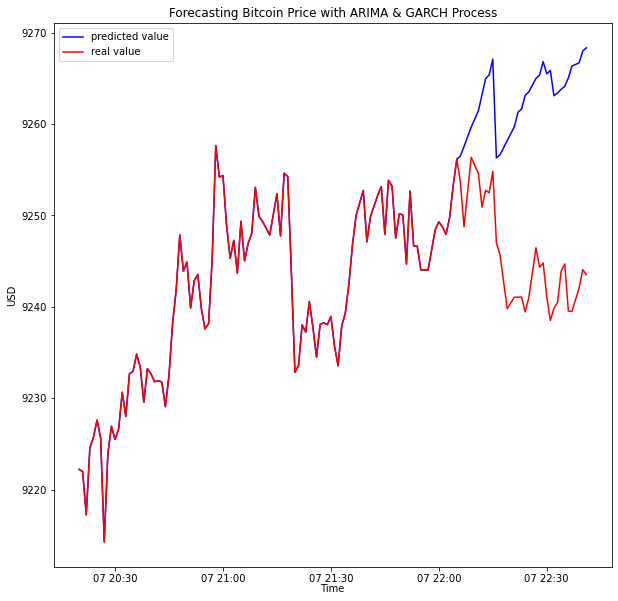

In [76]:
dy = df_train[len(df_train)-N:]['Weighted_Price']
dz = y_test[:M]
d = pd.concat([dy, dz])

index = df_train[len(df_train)-N:]['Time']
dzz = df_test[:M]['Time']
index= pd.concat([index, dzz])
index = pd.to_datetime(index)

plt.plot(index,df.values, color ='blue',label = "predicted value")
plt.plot(index,d.values,color='r',label = 'real value',)
plt.ylabel('USD')
plt.xlabel('Time',labelpad=0.1)
plt.title("Forecasting Bitcoin Price with ARIMA & GARCH Process")
plt.legend(loc='best')

# Processus de Hawkes

https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php download data for 2022

https://github.com/Pat-Laub/hawkesbook explication

In [201]:
def hawkes_intensity(t, ℋ_t, 𝛉):
    λ, μ, _ = 𝛉
    λˣ = λ
    for t_i in ℋ_t:
        λˣ += μ(t - t_i)
    return λˣ

In [ ]:
import hawkesbook as hawkes
#https://github.com/Pat-Laub/hawkesbook
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# Load data to fit
df = pd.read_csv("data/all_month.csv")
df_time = df['time']
df['Year'] = df['time'].astype(str).str[:4]
df['Month'] = pd.to_numeric(df_time.astype(str).str[5:7])
df['Day'] = df_time.astype(str).str[8:10]
df['Time'] = df_time.astype(str).str[11:19]
quakes = df
quakes.index = pd.to_datetime(quakes.Day.astype(str) + "/" + quakes.Month.astype(str) + "/" + quakes.Year.astype(str) + " " + quakes.Time, dayfirst=True)
quakes.sort_index(inplace=True)

# Calculate each arrival as a (fractional) number of days since the
# beginning of the observation period
timeToQuake = quakes.index - pd.Timestamp(year=2022, month=3, day=4)
ts = np.array(timeToQuake.total_seconds() / 60 / 60 / 24)

# Calculate the length of the observation period
obsPeriod = pd.Timestamp(year=2022, month=4, day=3) - pd.Timestamp(year=2022, month=3, day=3 )
T = obsPeriod.days

# Calculate the maximum likelihood estimate for the Hawkes process
# with an exponentially decaying intensity
𝛉_exp_mle = hawkes.exp_mle(ts, T)
print("Exp Hawkes MLE fit: ", 𝛉_exp_mle)

# Calculate the EM estimate or the same type of Hawkes process
𝛉_exp_em = hawkes.exp_em(ts, T, iters=100)
print("Exp Hawkes EM fit: ", 𝛉_exp_mle)

# Get the likelihoods of each fit to find the better one
ll_mle = hawkes.exp_log_likelihood(ts, T, 𝛉_exp_mle)
ll_em = hawkes.exp_log_likelihood(ts, T, 𝛉_exp_em)

if ll_mle > ll_em:
	print("MLE was a better fit than EM in this case")
	𝛉_exp = 𝛉_exp_mle
	ll_exp = ll_mle
else:
	print("EM was a better fit than MLE in this case")
	𝛉_exp = 𝛉_exp_em
	ll_exp = ll_em

# Fit instead the Hawkes with a power-law decay
𝛉_pl = hawkes.power_mle(ts, T)
ll_pl = hawkes.power_log_likelihood(ts, T, 𝛉_pl)

# Compare the BICs
BIC_exp = 3 * np.log(len(ts)) - 2 * ll_exp
BIC_pl = 4 * np.log(len(ts)) - 2 * ll_pl
if BIC_exp < BIC_pl:
	print(f"The exponentially-decaying Hawkes was the better fit with BIC={BIC_exp:.2f}.")
	print(f"The power-law Hawkes had BIC={BIC_pl:.2f}.")
else:
	print(f"The power-law Hawkes was the better fit with BIC={BIC_pl:.2f}.")
	print(f"The exponentially-decaying Hawkes had BIC={BIC_exp:.2f}.")

# Create a Q-Q plot for the exponential-decay fit by
# first transforming the points to a unit-rate Poisson
# process as outlined by the random time change theorem
tsShifted = hawkes.exp_hawkes_compensators(ts, 𝛉_exp)
iat = np.diff(np.insert(tsShifted, 0, 0))
qqplot(iat, dist=stats.expon, fit=False, line="45")
plt.show()


Exp Hawkes MLE fit:  [4.81328699 9.77880919 9.94260873]
Exp Hawkes EM fit:  [4.81328699 9.77880919 9.94260873]
MLE was a better fit than EM in this case
